In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.contingency_tables import StratifiedTable
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Загрузка данных

In [3]:
df = pd.read_csv('hw_aa.csv', sep=';', index_col=0)

## Первоначальный A/A Тест

  0%|          | 0/1000 [00:00<?, ?it/s]

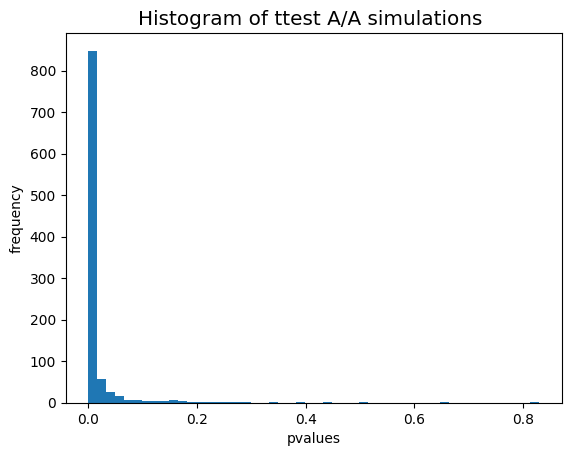

0.933

In [4]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

По резльтату A/A теста видно, что есть ошибка в разделители выборки.

## Исследование Причины Не Верного Деления 

In [8]:
StratifiedTable.from_data('purchase', 'experimentVariant', 'version', df).summary()

,Estimate,LCB,UCB
Pooled odds,2.300,2.161,2.447
Pooled log odds,0.833,0.771,0.895
Pooled risk ratio,1.657,,
,,,
,Statistic,P-value,
Test of OR=1,734.655,0.000,
Test constant OR,1256.880,0.000,
,,,
Number of tables,4,,
Min n,8425,,


In [9]:
(
    df
    .groupby(['experimentVariant', 'version'], as_index=False)
    .agg(
        obs = ('purchase', 'count'),
        conversion = ('purchase', 'mean')
    )
    .sort_values('version')
)

,experimentVariant,version,obs,conversion
0,0,v2.8.0,41283,0.000993
4,1,v2.8.0,41552,0.045606
1,0,v2.9.0,11921,0.074658
5,1,v2.9.0,12033,0.071304
2,0,v3.7.4.0,4204,0.059943
6,1,v3.7.4.0,4221,0.063018
3,0,v3.8.0.0,5694,0.057604
7,1,v3.8.0.0,6110,0.062848


Смотря на конверсию видно, что что-то пошло не так в версии "v2.8.0" для варианта "0". Следует исключить версию "v2.8.0" и посмотреть на результат A/A теста.

## A/A Тест без Версии 2.8.0

  0%|          | 0/1000 [00:00<?, ?it/s]

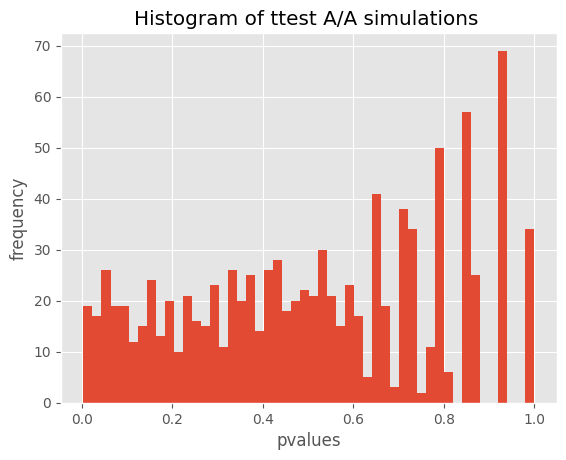

0.045

In [11]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 0 and version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 1 and version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR меньше 0.05 значит механика деление работает верно.  

## Заключение

По результатам анализа можно видеть, что изначальное деление было не верным. Черезвычайно низкая конверсия в варинте "0" и результат А/А теста меньше 0.05 после удаления версии 2.8.0 это подтверждают.  
Причина почему произошла ошибка не известна, но если более позднии версии были не затронуты, то есть высокая вероятность, что изминение в коде повлияли на изкажение в выборки. 